In [1290]:
import numpy as np
import pandas as pd
import lifelines as ll
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import matplotlib.pyplot as plt

#larger
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5

from time import time

from lifelines.estimation import KaplanMeierFitter

## Kaplan-Meier Survival Curves for Property Listings

In [844]:
#For listings data, they should be right-censored only. 
#That means for some listings we don’t know when they became pending, but we do know at least how many days they were listed.

In [845]:
import datetime
listings_df = pd.read_csv('SF_Apr15_Aug16.csv')
final_date = pd.to_datetime('2016-08-16')
start_date = pd.to_datetime('2016-04-15')

In [846]:
#Create derivative features
listings_df.pending_date = pd.to_datetime(listings_df.pending_date)
listings_df.listing_date = pd.to_datetime(listings_df.listing_date)
listings_df['days_til_pending'] = [diff.days if pd.notnull(diff) else 0 for diff in listings_df.pending_date - listings_df.listing_date]
listings_df['days_active_if_still_active'] = (final_date - listings_df.listing_date).dt.days
listings_df['price_psf'] = listings_df.price / listings_df.sqft
listings_df['price_per_bedroom'] = listings_df.price / listings_df.bedrooms
listings_df['bedrooms_per_sf'] = listings_df.bedrooms / listings_df.sqft
listings_df['price_per_bedroom_per_sf'] = listings_df.price / listings_df.bedrooms / listings_df.sqft
listings_df['home_age'] = 2016 - listings_df.year_built
listings_df['photos_per_psf'] = listings_df.photo_count / listings_df.price_psf
listings_df['home_age_psf'] = 2016 - listings_df.home_age / listings_df.price_psf

In [847]:
#alive = 0, dead = 1
listings_df['E'] = [0 if active == 0 else 1 for active in listings_df.days_til_pending]
listings_df['T'] = np.where(listings_df.days_til_pending == 0, listings_df.days_active_if_still_active, listings_df.days_til_pending)

In [848]:
listings_df.head(20)

,mprid,ldp_zip,listing_date,pending_date,ldp_views_day1,ldp_views_day3,ldp_views_day7,photo_count,type,bedrooms,...,days_active_if_still_active,price_psf,price_per_bedroom,bedrooms_per_sf,price_per_bedroom_per_sf,home_age,photos_per_psf,home_age_psf,E,T
0,1231040258,94513.0,2016-07-21,2016-07-26,75,224,353,28,single_family,4.0,...,26,195.579030,124975.000000,0.001565,48.894757,9.0,0.143165,2015.953983,1,5
1,1492199433,94513.0,2016-06-09,2016-06-16,42,147,272,30,single_family,4.0,...,68,248.739635,187487.500000,0.001327,62.184909,5.0,0.120608,2015.979899,1,7
2,2788062419,94528.0,2016-06-30,2016-06-30,10,26,46,1,single_family,4.0,...,47,728.947670,699972.000000,0.001041,182.236917,38.0,0.001372,2015.947870,0,47
3,1453235522,95035.0,2016-05-27,2016-06-01,10,320,360,27,single_family,3.0,...,81,699.806950,241666.666667,0.002896,233.268983,56.0,0.038582,2015.919978,1,5
4,1490255827,94521.0,2016-05-20,2016-05-27,108,308,546,24,condo,3.0,...,88,279.390421,128333.333333,0.002177,93.130140,43.0,0.085901,2015.846094,1,7
5,2875035505,94564.0,2016-08-10,NaT,18,77,156,18,single_family,3.0,...,6,412.500000,143000.000000,0.002885,137.500000,61.0,0.043636,2015.852121,0,6
6,1514245310,94107.0,2016-04-25,2016-06-16,24,59,70,36,condo,2.0,...,113,1191.973970,549500.000000,0.002169,595.986985,9.0,0.030202,2015.992449,1,52
7,2999607725,94028.0,2016-04-18,2016-05-24,5,27,59,25,single_family,5.0,...,120,1133.613445,539600.000000,0.002101,226.722689,58.0,0.022053,2015.948836,1,36
8,1141164069,94960.0,2016-06-09,2016-06-20,36,117,182,34,single_family,4.0,...,68,463.378906,237250.000000,0.001953,115.844727,108.0,0.073374,2015.766929,1,11
9,1417034577,94561.0,2016-07-08,2016-07-24,23,70,135,14,single_family,5.0,...,39,170.034642,117800.000000,0.001443,34.006928,10.0,0.082336,2015.941188,1,16


In [849]:
#Outlier functions - All return Boolean True if data point is an outlier

def is_outlier_mean(data, m = 3):
    return abs(data - np.mean(data)) > m * np.std(data)

# def is_outlier_modified_z_score(points, m=30):
#     if len(points.shape) == 1:
#         points = points[:,None]
#     median = np.median(points, axis=0)
#     diff = np.sum((points - median)**2, axis=-1)
#     diff = np.sqrt(diff)
#     med_abs_deviation = np.median(diff)

#     modified_z_score = 0.6745 * diff / med_abs_deviation

#     return modified_z_score > m

# def is_outliers_median(data, m = 30):
#     d = np.abs(data - np.median(data))
#     mdev = np.median(d)
#     s = d/mdev if mdev else 0.
#     return s > m

In [850]:
#FILTER OUT LISTINGS THAT WERE ACTIVE PRIOR TO FIRST DAY OF DATA (start_date)
#THIS PREVENTS "LEFT CENSORED" DATA - ASSUMING "TREATMENT DATES" IN THE DATASET ARE ALL THE SAME.
listings_df = listings_df[listings_df.listing_date > start_date]

#FILTER OUT "LAND", "MOBILE", "FARM"
listings_df = listings_df[(listings_df['type'] != 'land') & (listings_df['type'] != 'mobile') &  (listings_df['type'] != 'farm') ] 

#FILTER OUT HOMES < 100 SQFT
listings_df = listings_df[listings_df['sqft'] > 100]

#FILTER OUT HOMES WHERE # OF Bedrooms is NULL
listings_df = listings_df[pd.notnull(listings_df['bedrooms'])]

#FILTER OUT HOMES WHERE Age of Home is NULL
listings_df = listings_df[pd.notnull(listings_df['home_age'])]

#FILTER OUT HOMES WHERE Sq Ft is NULL
listings_df = listings_df[pd.notnull(listings_df['price_psf'])]

# FILTER OUT HOMES WHERE Photo Count is NULL
# listings_df = listings_df[pd.notnull(listings_df['photo_count'])]

#FILTER OUT PRICE OUTLIERS 
listings_df = listings_df[~is_outlier_mean(listings_df.price)]

In [851]:
listings_df.shape

(19871, 24)

In [852]:
listings_df.head(10)

,mprid,ldp_zip,listing_date,pending_date,ldp_views_day1,ldp_views_day3,ldp_views_day7,photo_count,type,bedrooms,...,days_active_if_still_active,price_psf,price_per_bedroom,bedrooms_per_sf,price_per_bedroom_per_sf,home_age,photos_per_psf,home_age_psf,E,T
0,1231040258,94513.0,2016-07-21,2016-07-26,75,224,353,28,single_family,4.0,...,26,195.579030,124975.000000,0.001565,48.894757,9.0,0.143165,2015.953983,1,5
1,1492199433,94513.0,2016-06-09,2016-06-16,42,147,272,30,single_family,4.0,...,68,248.739635,187487.500000,0.001327,62.184909,5.0,0.120608,2015.979899,1,7
2,2788062419,94528.0,2016-06-30,2016-06-30,10,26,46,1,single_family,4.0,...,47,728.947670,699972.000000,0.001041,182.236917,38.0,0.001372,2015.947870,0,47
3,1453235522,95035.0,2016-05-27,2016-06-01,10,320,360,27,single_family,3.0,...,81,699.806950,241666.666667,0.002896,233.268983,56.0,0.038582,2015.919978,1,5
4,1490255827,94521.0,2016-05-20,2016-05-27,108,308,546,24,condo,3.0,...,88,279.390421,128333.333333,0.002177,93.130140,43.0,0.085901,2015.846094,1,7
5,2875035505,94564.0,2016-08-10,NaT,18,77,156,18,single_family,3.0,...,6,412.500000,143000.000000,0.002885,137.500000,61.0,0.043636,2015.852121,0,6
6,1514245310,94107.0,2016-04-25,2016-06-16,24,59,70,36,condo,2.0,...,113,1191.973970,549500.000000,0.002169,595.986985,9.0,0.030202,2015.992449,1,52
7,2999607725,94028.0,2016-04-18,2016-05-24,5,27,59,25,single_family,5.0,...,120,1133.613445,539600.000000,0.002101,226.722689,58.0,0.022053,2015.948836,1,36
8,1141164069,94960.0,2016-06-09,2016-06-20,36,117,182,34,single_family,4.0,...,68,463.378906,237250.000000,0.001953,115.844727,108.0,0.073374,2015.766929,1,11
9,1417034577,94561.0,2016-07-08,2016-07-24,23,70,135,14,single_family,5.0,...,39,170.034642,117800.000000,0.001443,34.006928,10.0,0.082336,2015.941188,1,16


In [853]:
T = listings_df['T']
E = listings_df['E']

In [842]:
def config():
    plt.style.use('fivethirtyeight')
config()

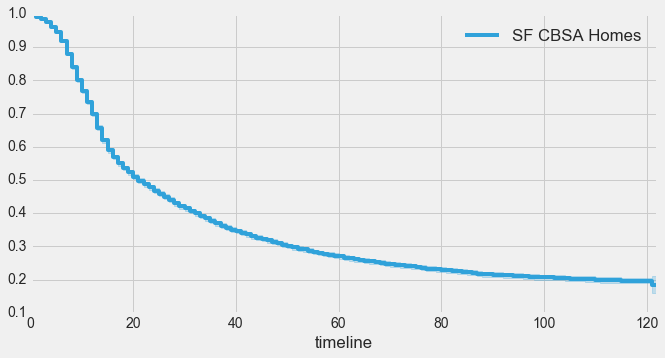

In [854]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
kmf.fit(T, event_observed=E, label = "SF CBSA Homes"); # more succiently, kmf.fit(T,E)

kmf.survival_function_
kmf.median_
kmf.plot(xlim = 0);

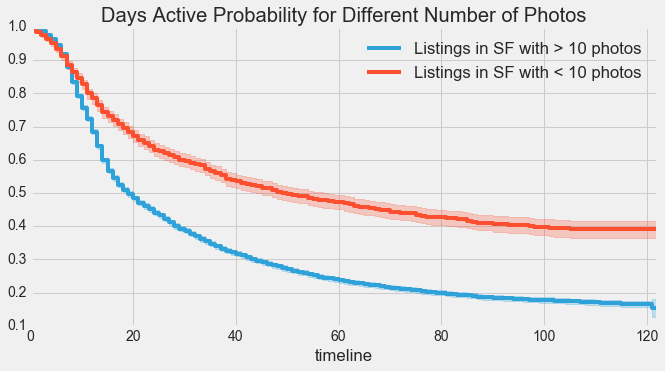

In [855]:
#Photo Counts
groups = listings_df['photo_count']
ten_photos_or_less = (groups <= 10)

kmf.fit(T[~ten_photos_or_less], E[~ten_photos_or_less], label='Listings in SF with > 10 photos')
ax = kmf.plot()

kmf.fit(T[ten_photos_or_less], E[ten_photos_or_less], label='Listings in SF with < 10 photos')
kmf.plot(xlim=0,ax=ax,title="Days Active Probability for Different Number of Photos");

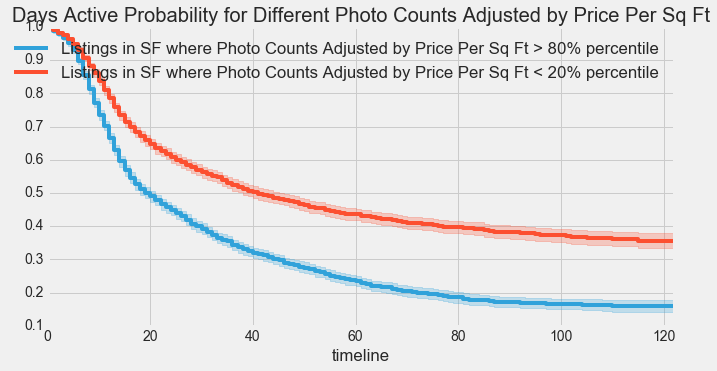

In [856]:
#Photo Counts Adjusted by Price Per Sq Ft
groups = listings_df['photos_per_psf']
more_photos_psf = (groups >= listings_df.photos_per_psf.quantile(.8))
fewer_photos_psf = (groups <= listings_df.photos_per_psf.quantile(.2))

kmf.fit(T[more_photos_psf], E[more_photos_psf], label='Listings in SF where Photo Counts Adjusted by Price Per Sq Ft > 80% percentile')
ax = kmf.plot()

kmf.fit(T[fewer_photos_psf], E[fewer_photos_psf], label='Listings in SF where Photo Counts Adjusted by Price Per Sq Ft < 20% percentile')
kmf.plot(xlim=0,ax=ax,title="Days Active Probability for Different Photo Counts Adjusted by Price Per Sq Ft");

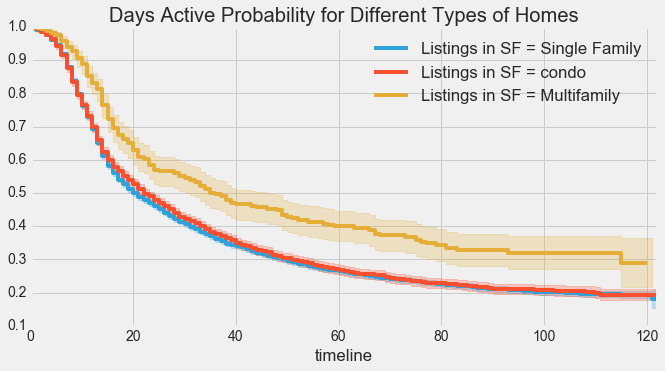

In [857]:
#Types of Home
groups = listings_df['type']
single = (groups == 'single_family')
multi = (groups == 'multi_family')
condo = (groups == 'condo')
ax = plt.subplot(111)

kmf.fit(T[single], E[single], label='Listings in SF = Single Family')
ax = kmf.plot(ax=ax)

kmf.fit(T[condo], E[condo], label='Listings in SF = condo')
ax = kmf.plot(ax=ax)

kmf.fit(T[multi], E[multi], label='Listings in SF = Multifamily')
kmf.plot(xlim=0,ax=ax,title="Days Active Probability for Different Types of Homes");

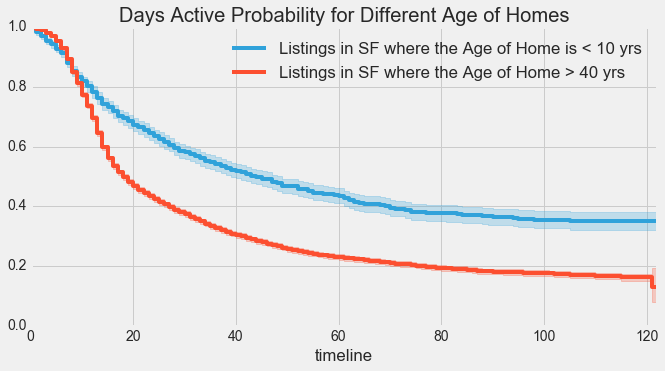

In [858]:
#Age of Homes
groups = listings_df['home_age']
new = (groups <= 10)
old = (groups >= 40)

kmf.fit(T[new], E[new], label='Listings in SF where the Age of Home is < 10 yrs')
ax = kmf.plot()

kmf.fit(T[old], E[old], label='Listings in SF where the Age of Home > 40 yrs')
kmf.plot(xlim=0,ax=ax,title="Days Active Probability for Different Age of Homes");

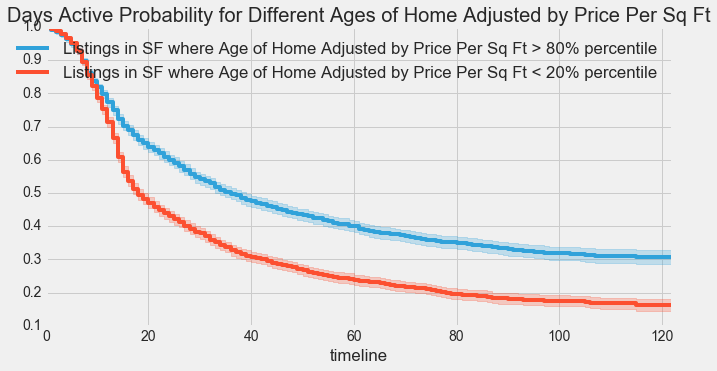

In [859]:
#Age of Home Adjusted by Price Per Sq Ft
groups = listings_df['home_age_psf']
more_photos_psf = (groups >= listings_df.home_age_psf.quantile(.8))
fewer_photos_psf = (groups <= listings_df.home_age_psf.quantile(.2))

kmf.fit(T[more_photos_psf], E[more_photos_psf], label='Listings in SF where Age of Home Adjusted by Price Per Sq Ft > 80% percentile')
ax = kmf.plot()

kmf.fit(T[fewer_photos_psf], E[fewer_photos_psf], label='Listings in SF where Age of Home Adjusted by Price Per Sq Ft < 20% percentile')
kmf.plot(xlim=0,ax=ax,title="Days Active Probability for Different Ages of Home Adjusted by Price Per Sq Ft");

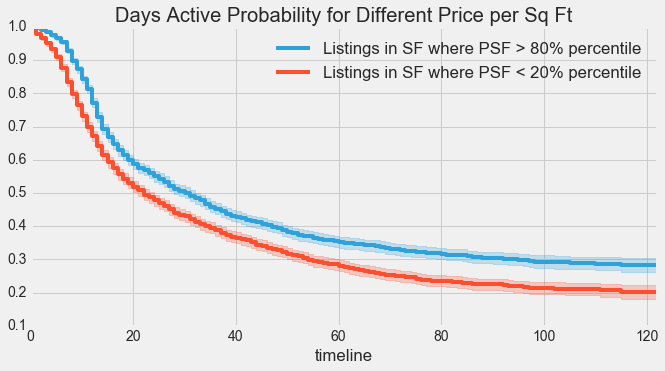

In [860]:
#Price Per SF
groups = listings_df['price_psf']
expensive = (groups >= listings_df.price_psf.quantile(.8))
cheap = (groups <= listings_df.price_psf.quantile(.2))

kmf.fit(T[expensive], E[expensive], label='Listings in SF where PSF > 80% percentile')
ax = kmf.plot()

kmf.fit(T[cheap], E[cheap], label='Listings in SF where PSF < 20% percentile')
kmf.plot(xlim=0,ax=ax,title="Days Active Probability for Different Price per Sq Ft");

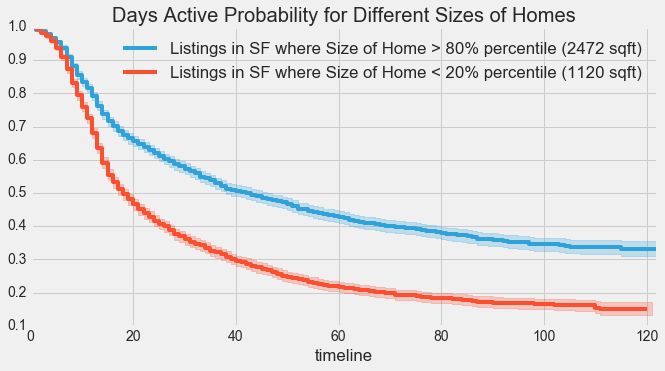

In [861]:
#Size of Home
groups = listings_df['sqft']
large = (groups >= listings_df.sqft.quantile(.8))
small = (groups <= listings_df.sqft.quantile(.2))

kmf.fit(T[large], E[large], label='Listings in SF where Size of Home > 80% percentile (2472 sqft)')
ax = kmf.plot()

kmf.fit(T[small], E[small], label='Listings in SF where Size of Home < 20% percentile (1120 sqft)')
kmf.plot(xlim=0,ax=ax,title="Days Active Probability for Different Sizes of Homes");

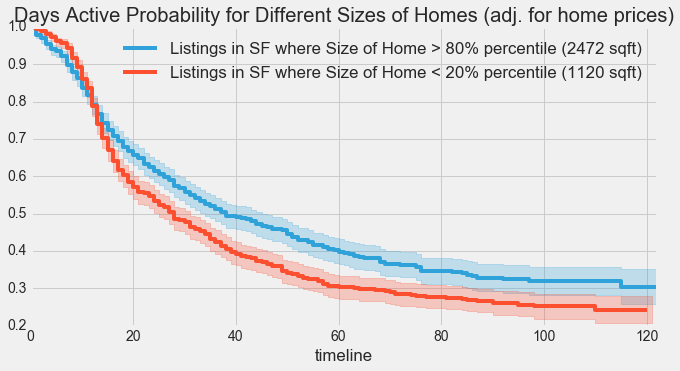

In [862]:
#Size of Home (Adjusted for Home Prices by looking at Large and Cheap Homes v Small and Expensive Homes)
groups = listings_df['sqft']
large = (groups >= listings_df.sqft.quantile(.8))
small = (groups <= listings_df.sqft.quantile(.2))

kmf.fit(T[large & cheap], E[large & cheap], label='Listings in SF where Size of Home > 80% percentile (2472 sqft)')
ax = kmf.plot()

kmf.fit(T[small & expensive], E[small & expensive], label='Listings in SF where Size of Home < 20% percentile (1120 sqft)')
kmf.plot(xlim=0,ax=ax,title="Days Active Probability for Different Sizes of Homes (adj. for home prices)");

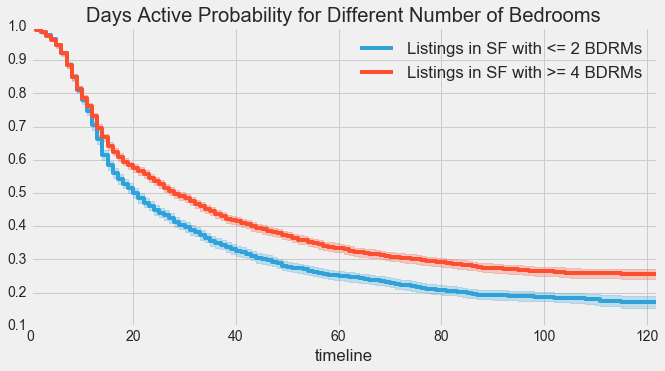

In [863]:
#Bedroom Counts
groups = listings_df['bedrooms']
two = (groups <= 2)
four = (groups >= 4)


kmf.fit(T[two], E[two], label='Listings in SF with <= 2 BDRMs')
ax = kmf.plot()

kmf.fit(T[four], E[four], label='Listings in SF with >= 4 BDRMs')
kmf.plot(xlim=0,ax=ax,title="Days Active Probability for Different Number of Bedrooms");

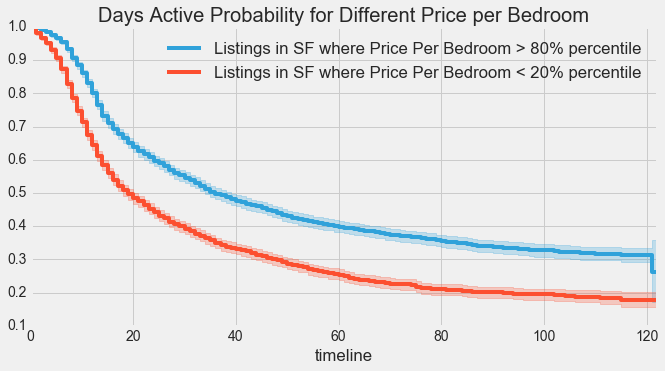

In [864]:
#Price Per Bedroom
groups = listings_df['price_per_bedroom']
expensive_per_bedroom = (groups >= listings_df.price_per_bedroom.quantile(.8))
cheap_per_bedroom = (groups <= listings_df.price_per_bedroom.quantile(.2))

kmf.fit(T[expensive_per_bedroom], E[expensive_per_bedroom], label='Listings in SF where Price Per Bedroom > 80% percentile')
ax = kmf.plot()

kmf.fit(T[cheap_per_bedroom], E[cheap_per_bedroom], label='Listings in SF where Price Per Bedroom < 20% percentile')
kmf.plot(xlim=0,ax=ax,title="Days Active Probability for Different Price per Bedroom");

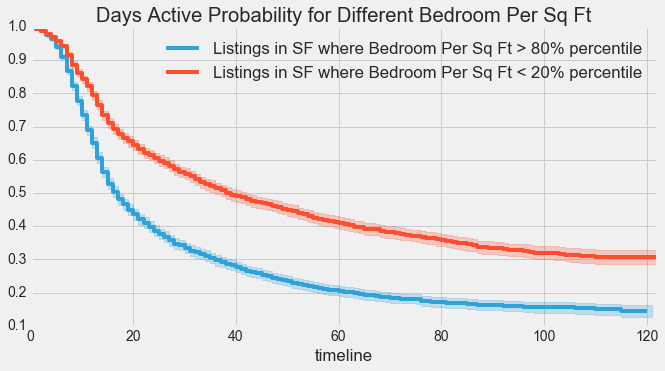

In [865]:
#Bedroom Per Sq Ft
groups = listings_df['bedrooms_per_sf']
more_bedrooms = (groups >= listings_df.bedrooms_per_sf.quantile(.8))
fewer_bedrooms = (groups <= listings_df.bedrooms_per_sf.quantile(.2))

kmf.fit(T[more_bedrooms], E[more_bedrooms], label='Listings in SF where Bedroom Per Sq Ft > 80% percentile')
ax = kmf.plot()

kmf.fit(T[fewer_bedrooms], E[fewer_bedrooms], label='Listings in SF where Bedroom Per Sq Ft < 20% percentile')
kmf.plot(xlim=0,ax=ax,title="Days Active Probability for Different Bedroom Per Sq Ft");

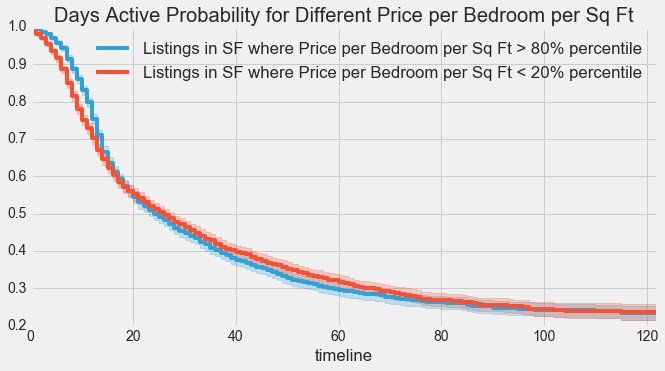

In [866]:
#Price per Bedroom per Sq Ft
groups = listings_df['price_per_bedroom_per_sf']
adjusted_expensive = (groups >= listings_df.price_per_bedroom_per_sf.quantile(.8))
adjusted_cheap = (groups <= listings_df.price_per_bedroom_per_sf.quantile(.2))

kmf.fit(T[adjusted_expensive], E[adjusted_expensive], label='Listings in SF where Price per Bedroom per Sq Ft > 80% percentile')
ax = kmf.plot()

kmf.fit(T[adjusted_cheap], E[adjusted_cheap], label='Listings in SF where Price per Bedroom per Sq Ft < 20% percentile')
kmf.plot(xlim=0,ax=ax,title="Days Active Probability for Different Price per Bedroom per Sq Ft");

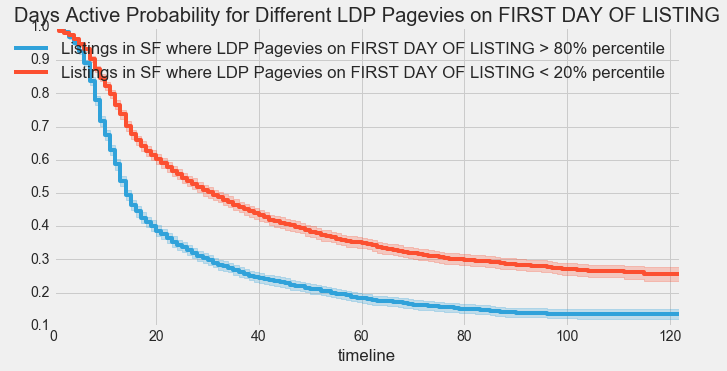

In [871]:
#Pageviews Day 1 of Listing
groups = listings_df['ldp_views_day1']
adjusted_many_views = (groups >= listings_df.ldp_views_day1.quantile(.8))
adjusted_few_views = (groups <= listings_df.ldp_views_day1.quantile(.2))

kmf.fit(T[adjusted_many_views], E[adjusted_many_views], label='Listings in SF where LDP Pagevies on FIRST DAY OF LISTING > 80% percentile')
ax = kmf.plot()

kmf.fit(T[adjusted_few_views], E[adjusted_few_views], label='Listings in SF where LDP Pagevies on FIRST DAY OF LISTING < 20% percentile')
kmf.plot(xlim=0,ax=ax,title="Days Active Probability for Different LDP Pagevies on FIRST DAY OF LISTING");

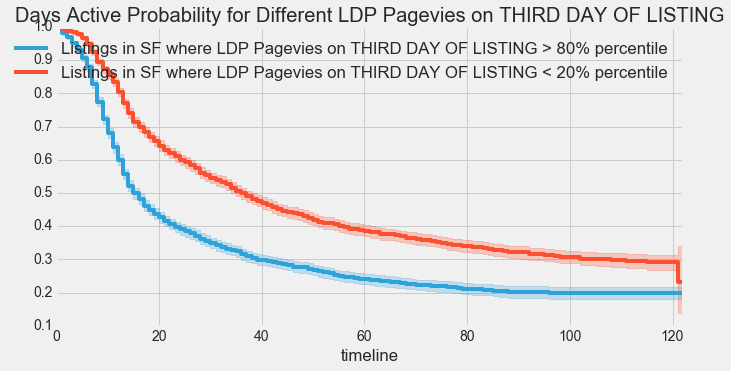

In [868]:
#Pageviews Day 3 of Listing
groups = listings_df['ldp_views_day3']
adjusted_many_views = (groups >= listings_df.ldp_views_day3.quantile(.8))
adjusted_few_views = (groups <= listings_df.ldp_views_day3.quantile(.2))

kmf.fit(T[adjusted_many_views], E[adjusted_many_views], label='Listings in SF where LDP Pagevies on THIRD DAY OF LISTING > 80% percentile')
ax = kmf.plot()

kmf.fit(T[adjusted_few_views], E[adjusted_few_views], label='Listings in SF where LDP Pagevies on THIRD DAY OF LISTING < 20% percentile')
kmf.plot(xlim=0,ax=ax,title="Days Active Probability for Different LDP Pagevies on THIRD DAY OF LISTING");

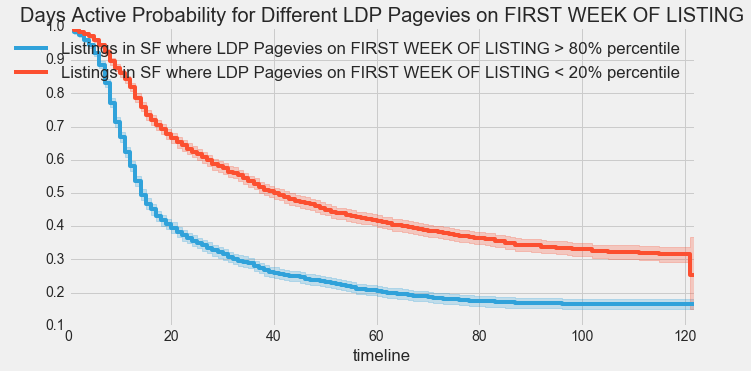

In [869]:
#Pageviews Day 7 of Listing
groups = listings_df['ldp_views_day7']
adjusted_many_views = (groups >= listings_df.ldp_views_day7.quantile(.8))
adjusted_few_views = (groups <= listings_df.ldp_views_day7.quantile(.2))

kmf.fit(T[adjusted_many_views], E[adjusted_many_views], label='Listings in SF where LDP Pagevies on FIRST WEEK OF LISTING > 80% percentile')
ax = kmf.plot()

kmf.fit(T[adjusted_few_views], E[adjusted_few_views], label='Listings in SF where LDP Pagevies on FIRST WEEK OF LISTING < 20% percentile')
kmf.plot(xlim=0,ax=ax,title="Days Active Probability for Different LDP Pagevies on FIRST WEEK OF LISTING");

## Cox Regression to Predict Days Active on RDC

In [940]:
cox_df = listings_df[['price','bedrooms','sqft','home_age','photo_count',
                      'ldp_views_day1','ldp_views_day3','ldp_views_day7',
                      'T','E']]

In [941]:
#Add Interaction Terms
cox_df['bedrooms*price'] = cox_df.bedrooms * cox_df.price
cox_df['sqft*price'] = cox_df.sqft * cox_df.price
cox_df['bedrooms*sqft'] = cox_df.bedrooms * cox_df.sqft
cox_df['psf'] = cox_df.price * 1.0 / cox_df.sqft #Couldn't converge when added

# cox_df['price_per_bedroom'] = cox_df.price / cox_df.bedrooms #Couldn't converge when added
# cox_df['bedroom_per_sqft'] = cox_df.bedrooms / cox_df.sqft #NOT SIGNIFICANT
# cox_df['bedrooms*sqft*price'] = cox_df.bedrooms * cox_df.sqft * cox_df.price #made many other variables not significant
# cox_df['photo_count*price'] = cox_df.photo_count * cox_df.price #NOT SIGNIFICANT
# cox_df['home_age*price'] = cox_df.home_age * cox_df.price #NOT SIGNIFICANT

T = cox_df['T']
E = cox_df['E']

In [942]:
cox_df.head()

,price,bedrooms,sqft,home_age,photo_count,ldp_views_day1,ldp_views_day3,ldp_views_day7,T,E,bedrooms*price,sqft*price,bedrooms*sqft,psf
0,499900.0,4.0,2556.0,9.0,28,75,224,353,5,1,1999600.0,1.277744e+09,10224.0,195.579030
1,749950.0,4.0,3015.0,5.0,30,42,147,272,7,1,2999800.0,2.261099e+09,12060.0,248.739635
2,2799888.0,4.0,3841.0,38.0,1,10,26,46,47,0,11199552.0,1.075437e+10,15364.0,728.947670
3,725000.0,3.0,1036.0,56.0,27,10,320,360,5,1,2175000.0,7.511000e+08,3108.0,699.806950
4,385000.0,3.0,1378.0,43.0,24,108,308,546,7,1,1155000.0,5.305300e+08,4134.0,279.390421


### Filter outliers for the "engineered" features


In [943]:
#Filter outliers in PSF
cox_df = cox_df[~is_outlier_mean(cox_df.psf)]

#Filter outliers in sqft*price
cox_df = cox_df[~is_outlier_mean(cox_df['sqft*price'])]

#Filter outliers in bedrooms*price
cox_df = cox_df[~is_outlier_mean(cox_df['bedrooms*price'])]


In [944]:
cox_df.shape

(18986, 14)

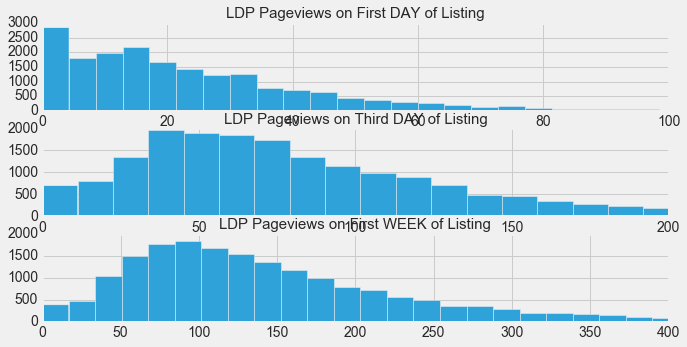

In [956]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3)

ax1.hist(cox_df.ldp_views_day1, bins=100)
ax1.set_title("LDP Pageviews on First DAY of Listing",fontsize=15)
ax1.set_xlim(0,100)

ax2.hist(cox_df.ldp_views_day3, bins=300)
ax2.set_title("LDP Pageviews on Third DAY of Listing",fontsize=15)
ax2.set_xlim(0,200)

ax3.hist(cox_df.ldp_views_day7, bins = 200)
ax3.set_title("LDP Pageviews on First WEEK of Listing", fontsize=15)
ax3.set_xlim(0,400)

plt.show()

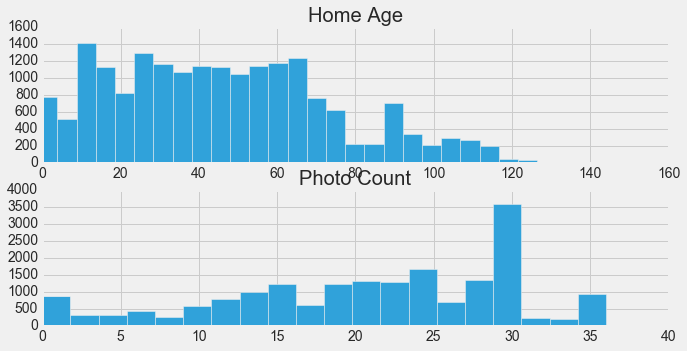

In [957]:
fig, (ax1, ax2) = plt.subplots(nrows=2)

ax1.hist(cox_df.home_age,bins=30)
ax1.set_title("Home Age")
ax1.set_xlim(0)

ax2.hist(cox_df.photo_count,bins=20)
ax2.set_title("Photo Count")
ax2.set_xlim(0)

plt.show()

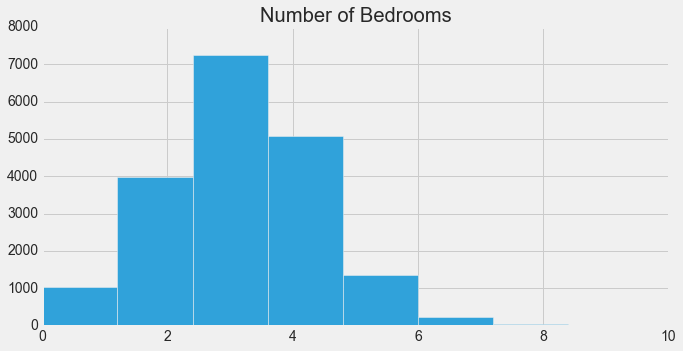

In [958]:
plt.hist(cox_df.bedrooms, bins=10)
plt.title("Number of Bedrooms")
plt.xlim(0,10)
plt.show();

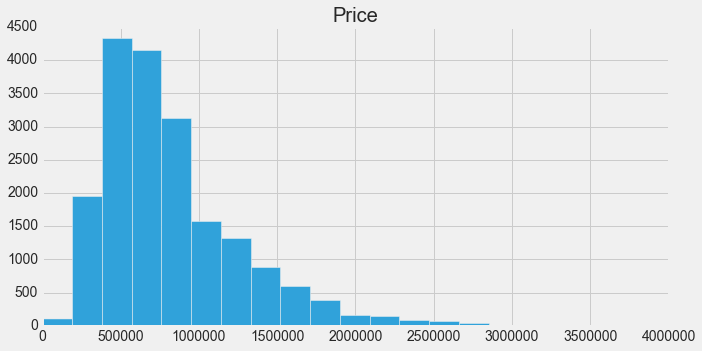

In [959]:
# filtered_price = cox_df.price[~is_outlier_mean(cox_df.price)]
hist, bin_edges = np.histogram(cox_df.price, bins=20)
plt.hist(cox_df.price, bin_edges)
plt.title("Price")
# plt.xlim(0,5000000)
plt.show();

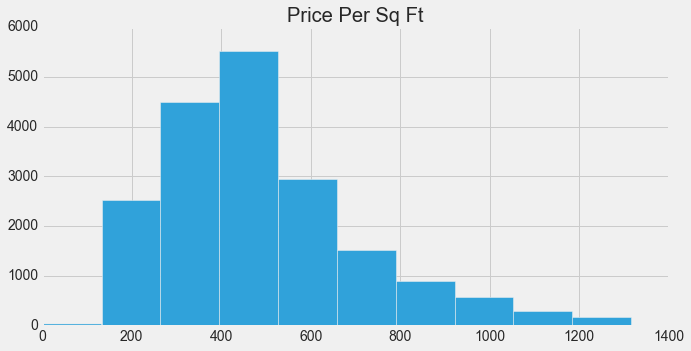

In [960]:
# filtered_psf = cox_df.psf[~is_outlier_mean(cox_df.psf)]
hist, bin_edges = np.histogram(cox_df.psf, bins=10)
plt.hist(cox_df.psf, bin_edges)
plt.title("Price Per Sq Ft")
plt.show();

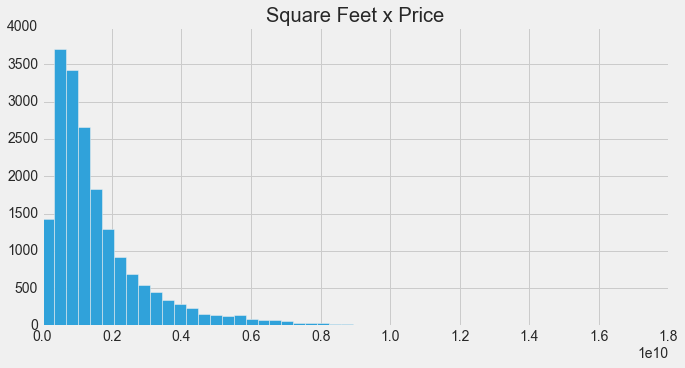

In [961]:
# filtered_sqftprice = cox_df.price[~is_outlier_mean(cox_df['sqft*price'])]
hist, bin_edges = np.histogram(cox_df['sqft*price'], bins=50)
plt.hist(cox_df['sqft*price'], bin_edges)
plt.title("Square Feet x Price")
plt.show();

In [962]:
#Log Transform SKEWED features
skewed_numeric_features = ['ldp_views_day1','ldp_views_day3','ldp_views_day7',
                           'price','sqft*price','bedrooms*price']

cox_df[skewed_numeric_features] = cox_df[skewed_numeric_features].applymap(lambda x: np.log10(x+1))

In [730]:
#Standardize remaining numeric features
# standardize_numeric_features = ['home_age', 'photo_count']

# mean_sd_numeric_features_from_model = dict()

# for feature in standardize_numeric_features:
#     mean_sd_numeric_features_from_model[feature] = (cox_df[feature].mean(), cox_df[feature].std(ddof=0))

In [731]:
# mean_sd_numeric_features_from_model

In [601]:
# for feature in standardize_numeric_features:
#     cox_df[feature] = (cox_df[feature] - mean_sd_numeric_features_from_model[feature][0]) / mean_sd_numeric_features_from_model[feature][1]

In [963]:
cox_df.head()

,price,bedrooms,sqft,home_age,photo_count,ldp_views_day1,ldp_views_day3,ldp_views_day7,T,E,bedrooms*price,sqft*price,bedrooms*sqft,psf
0,5.698884,4.0,2556.0,9.0,28,1.880814,2.352183,2.549003,5,1,6.300943,9.106444,10224.0,195.579030
1,5.875033,4.0,3015.0,5.0,30,1.633468,2.170262,2.436163,7,1,6.477092,9.354320,12060.0,248.739635
3,5.860339,3.0,1036.0,56.0,27,1.041393,2.506505,2.557507,5,1,6.337459,8.875698,3108.0,699.806950
4,5.585462,3.0,1378.0,43.0,24,2.037426,2.489958,2.737987,7,1,6.062582,8.724710,4134.0,279.390421
5,5.632458,3.0,1040.0,61.0,18,1.278754,1.892095,2.195900,6,0,6.109579,8.649491,3120.0,412.500000


### Training and testing the Cox Model

In [1520]:
final_features_for_cox_model = [
                                'bedrooms',
                                'photo_count',
                                'psf',
                                'bedrooms*sqft', 
                                'ldp_views_day1',
                                'ldp_views_day3',
                                'ldp_views_day7',
                                'T','E']


In [1521]:
final_df = cox_df[final_features_for_cox_model]

In [1522]:
pd.isnull(final_df).sum()

bedrooms          0
photo_count       0
psf               0
bedrooms*sqft     0
ldp_views_day1    0
ldp_views_day3    0
ldp_views_day7    0
T                 0
E                 0
dtype: int64

In [1523]:
#Hold out some data for testing
holdout_total = 2000
train_rows = np.random.choice(final_df.shape[0], holdout_total, replace = False)
test_rows = ~train_rows
train_df = final_df.iloc[train_rows]
test_df = final_df.iloc[test_rows]

In [1524]:
#Train a model using training set
from lifelines import CoxPHFitter

cf = CoxPHFitter()
cf.fit(train_df, 'T', 'E', include_likelihood=True)
cf.print_summary()

n=2000, number of events=1341

                     coef  exp(coef)  se(coef)          z         p  lower 0.95  upper 0.95     
bedrooms        2.550e-01  1.290e+00 5.640e-02  4.521e+00 6.169e-06   1.444e-01   3.655e-01  ***
photo_count     1.867e-01  1.205e+00 3.073e-02  6.075e+00 1.239e-09   1.264e-01   2.469e-01  ***
psf            -7.601e-02  9.268e-01 3.044e-02 -2.497e+00 1.253e-02  -1.357e-01  -1.633e-02    *
bedrooms*sqft  -4.527e-01  6.359e-01 6.175e-02 -7.331e+00 2.285e-13  -5.737e-01  -3.316e-01  ***
ldp_views_day1  1.643e-01  1.179e+00 3.842e-02  4.278e+00 1.888e-05   8.903e-02   2.397e-01  ***
ldp_views_day3 -2.570e-01  7.734e-01 5.323e-02 -4.828e+00 1.378e-06  -3.613e-01  -1.526e-01  ***
ldp_views_day7  3.266e-01  1.386e+00 5.527e-02  5.909e+00 3.441e-09   2.183e-01   4.350e-01  ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Concordance = 0.610


In [1525]:
#Out of the entire holdout set, only test those listings that have become pending
test_df = test_df[test_df['E']==1]

In [1526]:
result = pd.DataFrame()
result['median'] = cf.predict_median(test_df)[0.5].values
# result['75th_perc'] = cf.predict_percentile(test_df,.75)[0.75].values
# result['25th_perc'] = cf.predict_percentile(test_df,.25)[0.25].values
result['actual'] = test_df['T'].values

#Restrict dataset to only those with predicted median that is NOT "inf"
result = result[~np.isinf(result['median'])]

# #Replace High End estimate with Max days
# result['25th_perc'] = result['25th_perc'].replace([np.inf, -np.inf], (final_date - start_date).days)

# #Replace Low End estimate with Min days
# result['75th_perc'] = result['75th_perc'].replace([np.inf, -np.inf], 0)

# #Check how many are within range
# result['within_range'] = (result['75th_perc'] <= result['actual']) & (result['25th_perc'] >= result['actual'])

In [1527]:
result.head()

,median,actual
0,17.0,50
1,12.0,13
2,57.0,7
3,15.0,4
4,20.0,12


In [1528]:
hot_days = 20

# print "Percentage of predicted data points that fell within range", result['within_range'].sum() * 1.0 / result.shape[0]
# print

print "Rsults on Holdout Test set:"
print "---------------------------"
print

print "A 'Hot Listing' is defined as those listings that the model predicts to be sold within", hot_days, "days according to Cox Regression Model"

print "Total number of listings predicted:", result.shape[0]

print "Total number of Hot Listings (listings predicted to sell within", hot_days, "days):",\
result[result['median'] <= hot_days].shape[0]

print "Percentage of listings actually sold within", hot_days, 'days:', result[result['actual'] <= hot_days].shape[0] * 1.0 / result.shape[0]

print "Percentage of listings actually sold within", hot_days+15, 'days:', result[result['actual'] <= hot_days+15].shape[0] * 1.0 / result.shape[0]

print "If a listing is predicted to be a 'Hot Listing', what % of time did it actually sell within", hot_days, "days?",\
(result[result['median'] <= hot_days]['actual'] <= hot_days).sum() * 1.0 / result[result['median'] <= hot_days].shape[0]

print "If a listing is predicted to be a 'Hot Listing', what % of time did it actually sell within", hot_days + 10, "days?",\
(result[result['median'] <= hot_days]['actual'] <= hot_days + 10).sum() * 1.0 / result[result['median'] <= hot_days].shape[0]

Rsults on Holdout Test set:
---------------------------

A 'Hot Listing' is defined as those listings that the model predicts to be sold within 20 days according to Cox Regression Model
Total number of listings predicted: 1301
Total number of Hot Listings (listings predicted to sell within 20 days): 862
Percentage of listings actually sold within 20 days: 0.701767870869
Percentage of listings actually sold within 35 days: 0.865488086088
If a listing is predicted to be a 'Hot Listing', what % of time did it actually sell within 20 days? 0.736658932715
If a listing is predicted to be a 'Hot Listing', what % of time did it actually sell within 30 days? 0.856148491879


### Random Forest Classification on "Hot" or "Not" Homes

In [1435]:
forest_df = cox_df.copy()

In [1436]:
#Define "Hot" home: Went Pending and Sold within X days
sold_within = 20
forest_df['Hot'] = np.where((forest_df['E']==1) & (forest_df['T'] <= sold_within), 1, 0)
print 'Fraction of listings that are "Hot"', forest_df.Hot.sum() * 1.0 / forest_df.shape[0]

Fraction of listings that are "Hot" 0.461339934689


In [1437]:
final_features_for_classification_model = [
#                                 'price',
                                'bedrooms',
#                                 'home_age',
                                'photo_count',
#                                 'bedrooms*price',
#                                 'sqft*price',
                                'psf',
                                'bedrooms*sqft', 
                                'ldp_views_day1',
                                'ldp_views_day3',
                                'ldp_views_day7',
]

In [1438]:
forest_df = forest_df[["Hot"] + final_features_for_classification_model]
forest_df.head()

,Hot,bedrooms,photo_count,psf,bedrooms*sqft,ldp_views_day1,ldp_views_day3,ldp_views_day7
0,1,4.0,28,195.579030,10224.0,1.880814,2.352183,2.549003
1,1,4.0,30,248.739635,12060.0,1.633468,2.170262,2.436163
3,1,3.0,27,699.806950,3108.0,1.041393,2.506505,2.557507
4,1,3.0,24,279.390421,4134.0,2.037426,2.489958,2.737987
5,0,3.0,18,412.500000,3120.0,1.278754,1.892095,2.195900


In [1439]:
df_final_np = forest_df.values

In [1440]:
#UP-SAMPLING APPROACH - OVER-SAMPLE THE MINORITY CLASS
#Resample to take care of severe class imbalance issue
retained_rows = np.where(df_final_np[:,0]==1.0)[0]
churned_rows = np.where(df_final_np[:,0]==0.0)[0]

churned_percentage = 0.50
churned_sample_size = int(df_final_np.shape[0] * churned_percentage)
retained_sample_size = int(df_final_np.shape[0] * (1 - churned_percentage))

sampled_churned_rows = np.random.choice(churned_rows, churned_sample_size, replace=False)
sampled_retained_rows = np.random.choice(retained_rows, retained_sample_size, replace=True)

df_upsampled_final = np.concatenate((df_final_np[sampled_churned_rows], df_final_np[sampled_retained_rows]), axis=0)
X_final_np = df_upsampled_final[:,1:]
Y_final_np = df_upsampled_final[:,0]
df_upsampled_final.shape

(18986, 8)

In [1441]:
X_final_np.shape

(18986, 7)

In [1442]:
Y_final_np.shape

(18986,)

In [1443]:
print np.isinf(forest_df).sum().sum()
print np.isnan(forest_df).sum().sum()

0
0


In [1444]:
#Setting up K-fold CV function:
from sklearn.cross_validation import KFold, StratifiedKFold 
def run_cv(X,y,clf_class,**kwargs):
    # Construct a kfolds object
    # kf = KFold(len(y),n_folds=4,shuffle=True)
    #Stretified KFold preserves the class balance in the training and test samples
    #Better for when there's a class imbalance and after up/down-sampling
    kf = StratifiedKFold(y, n_folds=5)
    
    y_pred = y.copy()
    
    # Iterate through folds
    for train_index, test_index in kf:
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        # Initialize a classifier with key word arguments
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        y_pred[test_index] = clf.predict(X_test)
    return y_pred, clf

In [1445]:
#Cross-validation for various classification models:
#from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn import metrics 

def accuracy(y_true,y_pred):
    return np.mean(y_true == y_pred)

In [1446]:
start = time()
print "Logistic Regression:"
y_pred_log, logit_model = run_cv(X_final_np, Y_final_np, LogisticRegression,
                        C = 0.001,
                        penalty='l2'
                    )

print "%.3f" % accuracy(Y_final_np, y_pred_log)
print "training time:", time() - start

Logistic Regression:
0.586
training time: 0.227401018143


In [1447]:
from sklearn.ensemble import RandomForestClassifier as RF
start = time()
print "Random Forest:"
y_pred_rf, rf_model = run_cv(X_final_np, Y_final_np, RF,
                                 criterion = 'gini',
                                 n_estimators=100,
                                 #Restricts the width of each tree
                                 #If you create an ensemble, overfitting is not as much an issue
                                 min_samples_split = 20000/20, 
                                 #Restricts depth of tree to 10
#                                  max_depth = 10, 
                                 max_features = 'sqrt',
                                 n_jobs=-1
                    )

print "%.3f" % accuracy(Y_final_np, y_pred_rf)
# X_pre_sampling = df_final.values[:,1:]
print "training time:", time() - start

Random Forest:
0.626
training time: 3.93072915077


In [1448]:
from sklearn.ensemble import GradientBoostingClassifier as GB
start = time()
print "Gradient Boosting:"
y_pred_gb, gb_model = run_cv(X_final_np, Y_final_np, GB,
                                 n_estimators=200, 
                                 learning_rate=0.01,
                                 max_depth=3, 
                                 random_state=0
                    )

print "%.3f" % accuracy(Y_final_np, y_pred_gb)
# X_pre_sampling = df_final.values[:,1:]
print "training time:", time() - start

Gradient Boosting:
0.623
training time: 7.48851799965
